## Accessing GOES data with the Planetary Computer STAC API

The [Cloud and Moisture Imagery](https://planetarycomputer.microsoft.com/dataset/goes-cmi) product contains one or more Earth-view images with pixel values identifying brightness values that are scaled to support visual analysis.

### Data Access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

This example will load data from the `goes-cmi` collection and plot it. We'll select a date and time that captures images of Hurricane Florence.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

bbox = [-67.2729, 25.6000, -61.7999, 27.5423]
search = catalog.search(
    collections=["goes-cmi"],
    bbox=bbox,
    datetime=["2018-09-11T13:00:00Z", "2018-09-11T15:40:00Z"],
    limit=1,
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)

item = next(search.items())

The GOES-CMI items have many assets available for the various bands. You can view the full list at https://planetarycomputer.microsoft.com/dataset/goes-cmi. We'll use the blue, red, and near-infrared bands.

In [2]:
import rioxarray
import xarray as xr

bands = ["C01_2km", "C02_2km", "C03_2km"]
common_names = [
    item.assets[band].extra_fields["eo:bands"][0]["common_name"] for band in bands
]
ds = xr.concat(
    [rioxarray.open_rasterio(item.assets[band].href) for band in bands], dim="band"
).assign_coords(band=common_names)
ds

<xarray.DataArray 'CMI_C01' (band: 3, y: 500, x: 500)>
array([[[ 659,  744,  840, ...,  390,  391,  395],
        [ 602,  742,  817, ...,  390,  391,  392],
        [ 560,  695,  762, ...,  388,  389,  393],
        ...,
        [ 451,  855,  947, ...,  377,  390,  368],
        [ 627, 1028, 1261, ...,  367,  362,  363],
        [1058, 1047, 1400, ...,  367,  362,  391]],

       [[ 444,  522,  634, ...,  117,  117,  116],
        [ 390,  536,  613, ...,  116,  111,  111],
        [ 339,  479,  546, ...,  115,  113,  113],
        ...,
        [ 221,  714,  805, ...,  119,  142,  109],
        [ 425,  911, 1165, ...,  112,  107,  106],
        [ 940,  902, 1321, ...,  111,  105,  136]],

       [[ 393,  480,  593, ...,   54,   52,   53],
        [ 341,  493,  564, ...,   51,   51,   49],
        [ 292,  432,  494, ...,   51,   50,   51],
        ...,
        [ 173,  699,  811, ...,   70,   91,   57],
        [ 412,  916, 1189, ...,   58,   50,   50],
        [ 977,  932, 1385, ...,   57,   49,   87]]], dtype=int16)
Coordinates:
  * band                    (band) <U5 'blue' 'red' 'nir09'
  * x                       (x) float64 3.206e+05 3.226e+05 ... 1.321e+06
  * y                       (y) float64 3.367e+06 3.365e+06 ... 2.367e+06
    goes_imager_projection  int64 0
Attributes:
    add_offset:             0.0
    ancillary_variables:    DQF_C01
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    coordinates:            band_id_C01 band_wavelength_C01 t y x
    downsampling_method:    average
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    resolution:             y: 0.000056 rad x: 0.000056 rad
    scale_factor:           0.00031746001332066953
    sensor_band_bit_depth:  10
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    units:                  1
    valid_range:            [   0. 4095.]
    _FillValue:             -1.0
    _Unsigned:              true

GOES doesn't have a true green band, which we need for our true color image. We'll simulate it with a linear combination of the other bands (See [Bah et. al (2018)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) for more on this technique).

In [3]:
green = (
    0.45 * ds.sel(band="red") + 0.1 * ds.sel(band="nir09") + 0.45 * ds.sel(band="blue")
).assign_coords(band="green")
green

<xarray.DataArray 'CMI_C01' (y: 500, x: 500)>
array([[ 535.65,  617.7 ,  722.6 , ...,  233.55,  233.8 ,  235.25],
       [ 480.5 ,  624.4 ,  699.9 , ...,  232.8 ,  231.  ,  231.25],
       [ 433.75,  571.5 ,  638.  , ...,  231.45,  230.9 ,  232.8 ],
       ...,
       [ 319.7 ,  775.95,  869.5 , ...,  230.2 ,  248.5 ,  220.35],
       [ 514.6 ,  964.15, 1210.6 , ...,  221.35,  216.05,  216.05],
       [ 996.8 ,  970.25, 1362.95, ...,  220.8 ,  215.05,  245.85]])
Coordinates:
  * x                       (x) float64 3.206e+05 3.226e+05 ... 1.321e+06
  * y                       (y) float64 3.367e+06 3.365e+06 ... 2.367e+06
    goes_imager_projection  int64 0
    band                    <U5 'green'

Finally, we'll apply a color correction.

In [4]:
import numpy as np

γ = 2.2

rgb = xr.concat([ds, green], dim="band").sel(band=["red", "green", "blue"])
rgb = rgb / rgb.max(dim=["band", "y", "x"])
rgb = np.clip(rgb ** (1 / γ), 0, 1)

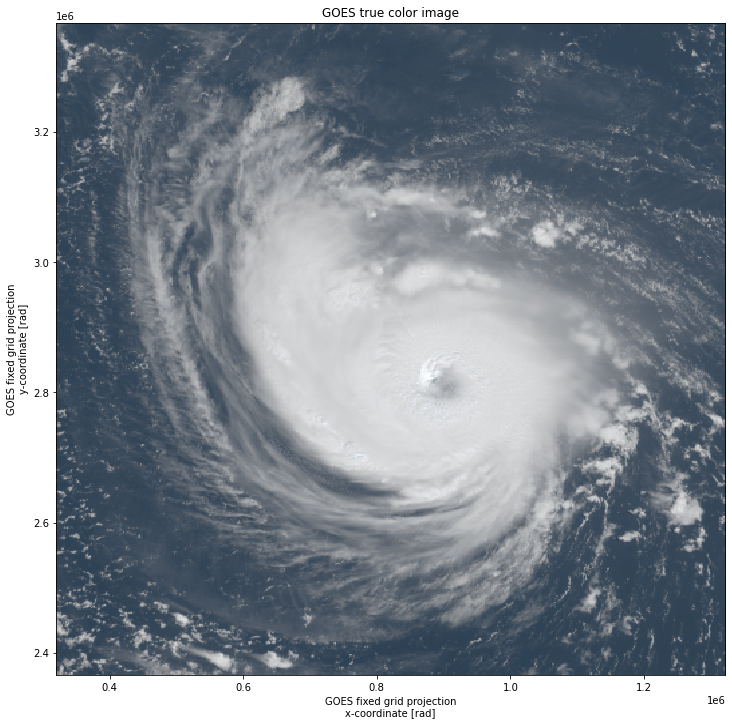

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

rgb.plot.imshow(rgb="band", ax=ax)
ax.set(title="GOES true color image");